In [1]:
import sys
import os
sys.path.append('../../')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import mdlcstat_adwin1
from functools import partial
%matplotlib inline
import pandas as pd
import datetime as dt
from copy import deepcopy
import multiprocessing as multi
from multiprocessing import Pool
import scipy.linalg as sl

In [2]:
def specify_startingpoint(ctr):
    filename = 'covid19.csv'
    #df_all = pd.read_csv(filename)  
    df_all=pd.read_excel("../../data/COVID-19-geographic-disbtribution-worldwide-2020-12-14.xlsx")
    category = 'cases' ## we only studied the time series of cases
    ## list of countries with no less than 10,000 cumulative cases by Apr. 30
    candidates_country = ['Austria'
                          , 'Belarus', 'Belgium', 'Brazil', 
                          'Canada', 'Chile', 'China', 'Ecuador', 'France', 'Germany', 
                          'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 
                          'Mexico', 'Netherlands', 
                          'Pakistan', 'Peru', 'Poland', 'Portugal',
                          'Qatar', 'Romania', 'Russia', 'Saudi_Arabia', 
                          'Singapore', 'South_Korea', 'Spain', 'Sweden', 
                          'Switzerland', 'Turkey', 'Ukraine', 'United_Arab_Emirates',
                          'United_Kingdom', 'United_States_of_America']

    
    df_candidates = pd.DataFrame(columns=['country', 'date', 'cases'])
    
    for index, row in df_all.iterrows():
        if row['countriesAndTerritories'] in candidates_country:
            date = dt.datetime(row['year'], row['month'], row['day'])
            df_candidates = df_candidates.append({'country': row['countriesAndTerritories'], 'date': date, 
                                                 'cases': row['cases']},
                                                 ignore_index=True)

    t = np.arange(dt.datetime(2020, 1, 1), dt.datetime(2020, 5, 1), dt.timedelta(days=1)) ## The timeline for online detection
    
    t_candidates = []
    t_num = []
    for date_tmp in t:
        row = df_candidates.loc[(df_candidates['country'] == ctr) & (df_candidates['date'] == date_tmp)]
        if len(row[category].values) > 0 and (row[category].values[0] > 0):
            t_candidates.append(date_tmp)
            t_num.append(row[category].values[0])  
        else:
            if len(t_num) <= 10 and np.mean(t_num) <= 1:
                t_candidates = []
                t_num = []
            else:
                t_candidates.append(date_tmp)
                t_num.append(0)
    
    return pd.to_datetime(t_candidates[0])
            
    
def preprocessing(ctr):#prepare data
    """
    Return a dataframe that contains date and logarithm of cumulative cases in a country.
    
    parameters:
        ctr: country name
    
    returns:
        dataframe with date and logarithm of cumulative cases
    """
    #df=pd.read_csv('../../data/covid_data.csv')
    df=pd.read_excel("../../data/COVID-19-geographic-disbtribution-worldwide-2020-12-14.xlsx")
    df=df[df["countriesAndTerritories"]==ctr][["dateRep", "cases"]]
    df["dateRep"]=pd.to_datetime(df["dateRep"], format="%d/%m/%Y")
    df=df.sort_values("dateRep").reset_index(drop=True)
    df.columns=["date", ctr]

    starting_date=specify_startingpoint(ctr)
    
    deadline=pd.to_datetime("2020-4-30")
    df=df[(starting_date<=df["date"]) & (df["date"]<=deadline) ].reset_index(drop=True)
    
    df[ctr][0]=1
    df[ctr]=df[ctr].cumsum()
        
    df=df.reset_index(drop=True)
    df[ctr]=np.log(df[ctr])

    return df

In [3]:
def calculate_alpha(params):# adjust alpha
    """
    Calculate upper-bounds of hypothesis testings given by 1st and 2nd from data.
    
    parameters:
        params: hyperparameters for calculating LNML of Gaussian
    
    returns:
        alpha_1, alpha_2
    """
    country="Japan"
    df=preprocessing(country)
    events=[pd.to_datetime('2020/2/27')]
    #lnml_gaussian=partial(mdlcstat_adwin1.lnml_gaussian, sigma_given=params['sigma_given']) 
    nml_regression=mdlcstat_adwin1.nml_regression
    #complexity_regression=mdlcstat_adwin1.complexity_regression
    #batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=lnml_gaussian,d=2,alpha=1,delta=0.05,how_to_drop='all', preprocess=True)
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=nml_regression,d=3,alpha=1,delta=0.05,how_to_drop='all', preprocess=False)

    #ret_window, cut, mdl_0, mdl_1, mdl_2, alarm_0_p, alarm_0_m, alarm_1, alarm_2 = batch_adwin1.decision_function(np.array(df[country]))
    ret_window, cut, mdl_0, mdl_1, mdl_2, alarm_0, alarm_1, alarm_2 = batch_adwin1.decision_function(np.array(df[country]))

    
    event_at=len(df[df['date']<events[0]])
    dif_1=0
    dif_2=0
    
    if np.isnan(mdl_1[event_at])==False:
        dif_1=0
    else:
        abs_dif=1
        while True:
            stat_p=mdl_1[event_at+abs_dif]
            stat_m=mdl_1[event_at-abs_dif]
            
            if np.isnan(stat_p)==True and np.isnan(stat_m)==True:
                abs_dif+=1
                continue
            elif np.isnan(stat_p)==False and np.isnan(stat_m)==False:
                if stat_p>stat_m:
                    dif_1=abs_dif
                    break
                else:
                    dif_1=-abs_dif
                    break
            else:
                if np.isnan(stat_p)==False:
                    dif_1=abs_dif
                    break
                else:
                    dif_1=-abs_dif
                    break

    if np.isnan(mdl_2[event_at])==False:
        dif_2=0
    else:
        abs_dif=1
        while True:
            stat_p=mdl_2[event_at+abs_dif]
            stat_m=mdl_2[event_at-abs_dif]
            
            if np.isnan(stat_p)==True and np.isnan(stat_m)==True:#どっちもnan
                abs_dif+=1
                continue
            elif np.isnan(stat_p)==False and np.isnan(stat_m)==False:
                if stat_p>stat_m:
                    dif_2=abs_dif
                    break
                else:
                    dif_2=-abs_dif
                    break
            else:
                if np.isnan(stat_p)==False:
                    dif_2=abs_dif
                    break
                else:
                    dif_2=-abs_dif
                    break
                    
    if ret_window[event_at+dif_1]==0:
        win_1=ret_window[event_at+dif_1-1]+1
    else:
        win_1=ret_window[event_at+dif_1]
        
    if ret_window[event_at+dif_2]==0:
        win_2=ret_window[event_at+dif_2-1]+1
    else:
        win_2=ret_window[event_at+dif_2]
        
    alpha_1=np.exp(2*np.log(win_1/2)-mdl_1[event_at])
    alpha_2=np.exp(2*np.log(win_2/2)-mdl_2[event_at]/2)    
    
    # if alpha exceeds 1, set them 0.99.
    if alpha_1>1:
        alpha_1=0.99
    if alpha_2>1:
        alpha_2=0.99
    
    return alpha_1, alpha_2


In [4]:
def separate_changepoints(data, alarm, cut):
    alarm_p=[]
    alarm_m=[]

    for i in range(len(alarm)):
        if i==0:
            data_before=data[0:cut[i]]
            data_after=data[cut[i]:alarm[i]+1]
        else:
            data_before=data[alarm[i-1]+1:cut[i]]
            data_after=data[cut[i]:alarm[i]+1]            
            
        data_before= np.matrix(data_before).T
        n=data_before.shape[0]
        W = np.ones((2, n))
        W[1, :] = np.arange(1, n + 1)
        beta_before = sl.pinv(W.dot(W.T)).dot(W).dot(data_before)
        
        data_after= np.matrix(data_after).T
        n=data_after.shape[0]
        W = np.ones((2, n))
        W[1, :] = np.arange(1, n + 1)
        beta_after = sl.pinv(W.dot(W.T)).dot(W).dot(data_after)
        
        beta_before = np.squeeze(np.asarray(beta_before))
        beta_after = np.squeeze(np.asarray(beta_after))
        
        if beta_before[1]<beta_after[1]:
            alarm_p.append(alarm[i])
        else:
            alarm_m.append(alarm[i])
        
    print(alarm)
    print(alarm_p)
    print(alarm_m)
    
    return np.array(alarm_p), np.array(alarm_m)

def country_graph(country, events, params):
    """
    Plot a graphs for each country.
    parameters:
        country: country name
        events: date of events for enforcement of social distancing
        params: hyperparameters for calculating statistics
    """
    if country == "Korea, South":
        ctr="South_Korea"
        printctr="South Korea"
    elif country == "US":
        ctr="United_States_of_America"
        printctr="United States of America"
    elif country=="Saudi Arabia":
        ctr="Saudi_Arabia"
        printctr="Saudi Arabia"
    elif country=="United Arab Emirates":
        ctr="United_Arab_Emirates"
        printctr="United Arab Emirates"
    elif country=="United Kingdom":
        ctr="United_Kingdom"
        printctr="United Kingdom"
    else:
        ctr=country
        printctr=country
    
    #data preprocessing
    df=preprocessing(ctr)
    
    start=df['date'][0]
    end=df['date'][len(df['date'])-1]
            
    alpha_1=params["alpha_1"]
    alpha_2=params["alpha_2"]

    nml_regression=mdlcstat_adwin1.nml_regression

    #calculate statistics with tuned alpha
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=nml_regression,d=3,alpha=alpha_1,delta=0.05,how_to_drop='all', preprocess=False)
    ret_window, cut, mdl_0, mdl_1, _, alarm_0, alarm_1, _ =batch_adwin1.decision_function(np.array(df[ctr]))
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=nml_regression,d=3,alpha=alpha_2,delta=0.05,how_to_drop='all', preprocess=False)
    _, _, _, _, mdl_2, _, _, alarm_2 =batch_adwin1.decision_function(np.array(df[ctr]))    
    
    mdl_1=np.nan_to_num(mdl_1)
    mdl_2=np.nan_to_num(mdl_2)

    
    #alarm_0=np.r_[alarm_0_p,alarm_0_m]
    alarm_0=np.sort(alarm_0)
    cut=cut[np.where(cut!=-1)]
    
    for i in range(len(cut)):
        if i!=0:
            cut[i]+=alarm_0[i-1]+1
            
    alarm_0_index=deepcopy(alarm_0)
    alarm_1_index=deepcopy(alarm_1)
    alarm_2_index=deepcopy(alarm_2)
    
    alarm_1_index_ret=deepcopy(alarm_1)
    alarm_2_index_ret=deepcopy(alarm_2)    
    
    #separate change points
    alarm_0_p, alarm_0_m=separate_changepoints(np.array(df[ctr]), alarm_0, cut)
    
    if len(alarm_0_p)!=0:
        for i in range(len(alarm_0_p)):
            if len(alarm_0_index[alarm_0_index<alarm_0_p[i]])==0:
                start=0
                end=alarm_0_p[i]
            else:
                start=alarm_0_index[alarm_0_index<alarm_0_p[i]][-1]+1
                end=alarm_0_p[i]
                
            alarm_1_index_ret=alarm_1_index_ret[(alarm_1_index_ret<start) | (alarm_1_index_ret>end)]
            alarm_2_index_ret=alarm_2_index_ret[(alarm_2_index_ret<start) | (alarm_2_index_ret>end)]            
    
    
    alarm_0=df['date'][alarm_0].reset_index(drop=True)
    #alarm_0_p=df['date'][alarm_0_p].reset_index(drop=True)  
    #alarm_0_m=df['date'][alarm_0_m].reset_index(drop=True)
    alarm_1=df['date'][alarm_1].reset_index(drop=True)
    alarm_2=df['date'][alarm_2].reset_index(drop=True)
    cut=df['date'][cut].reset_index(drop=True)
    
    #Linchuanの調整
    cumcases=np.exp(np.copy(np.array(df[ctr])))
    local_cumcases=np.exp(np.copy(np.array(df[ctr])))
    localcum_supplementary=[]
    
    for i in range(len(alarm_0_index)):
        if i==0:
            localcum_supplementary.append(cumcases[alarm_0_index[i]])
        else:
            localcum_supplementary.append(cumcases[alarm_0_index[i]]-cumcases[alarm_0_index[i-1]])
        
        if alarm_0_index[i]+1 != len(cumcases):
            local_cumcases[alarm_0_index[i]:]=cumcases[alarm_0_index[i]:]-cumcases[alarm_0_index[i]]+1
            #print(df_cumcases)

    localcum_supplementary=np.array(localcum_supplementary)
            
    df_localcum=pd.DataFrame({'date': df['date'].values, 'local_cumcases': local_cumcases})
    df_supplementary=pd.DataFrame({'date': df['date'][alarm_0_index].values, 'local_cumcases': localcum_supplementary})
    df_concat_localcum=pd.concat([df_localcum, df_supplementary], axis=0)
    df_concat_localcum=df_concat_localcum.sort_values(['date','local_cumcases'], ascending=[False, True])
    
    
    print('date for alarms of 0th D-MDL')
    print(alarm_0)
    print('cutpoint')
    print(cut)


    #plot data
    #0th D-MDL    
    plt.clf()
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot(df['date'], mdl_0/np.nanmax(mdl_0)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('0th D-MDL change score')

    ##for marking changes 
    for p_index in alarm_0_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_0[p_index]/np.nanmax(mdl_0), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    #plt.xlim(start-dt.timedelta(days=5),end+dt.timedelta(days=5))
    #plt.xlim(start, end)
    
    plt.ylim(0,1.1)
    plt.tight_layout()
    
    if country == "Korea, South":
        plt.savefig('../../exponential_figs/'+'South_Korea'+'_0_score.eps')
    else:
        plt.savefig('../../exponential_figs/'+country+'_0_score.eps')

        
    #1st D-MDL
    plt.clf()
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], mdl_1/np.nanmax(mdl_1)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('1st D-MDL change score')

    ##for marking signs of changes 
    for p_index in alarm_1_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_1[p_index]/np.nanmax(mdl_1), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    #plt.xlim(start-dt.timedelta(days=5),end+dt.timedelta(days=5))
    #plt.xlim(start, end)
    plt.ylim(0,1.1)
    plt.tight_layout()
    #plt.savefig('../../figs/'+country+'_1_score.eps')
    
    if country == "Korea, South":
        plt.savefig('../../exponential_figs/'+'South_Korea'+'_1_score.eps')
    else:
        plt.savefig('../../exponential_figs/'+country+'_1_score.eps')
     
    #2nd D-MDL
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], mdl_2/np.nanmax(mdl_2)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('2nd D-MDL change score')

    ##for marking signs of changes 
    for p_index in alarm_2_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_2[p_index]/np.nanmax(mdl_2), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    #plt.xlim(start-dt.timedelta(days=5),end+dt.timedelta(days=5))
    #plt.xlim(start, end)
    plt.ylim(0,1.1)
    plt.tight_layout()
    #plt.savefig('../../figs/'+country+'_2_score.eps')
    
    if country == "Korea, South":
        plt.savefig('../../exponential_figs/'+'South_Korea'+'_2_score.eps')
    else:
        plt.savefig('../../exponential_figs/'+country+'_2_score.eps')
    
    #cases
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    #plt.plot(df['date'], np.exp(df[ctr]))## dates in datetime format and change scores
    #plt.plot(df['date'], df_cumcases)## dates in datetime format and change scores
    df_concat_localcum["local_cumcases"][0]=1
    plt.plot(df_concat_localcum["date"], df_concat_localcum["local_cumcases"])## dates in datetime format and change scores
    

    plt.gcf().autofmt_xdate()
    plt.yscale('log')
    plt.title(printctr)
    plt.ylabel('Local cumulative cases')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=max(np.exp(df[ctr]))**2, color='black', linestyle='-',linewidth=2)
    plt.text(events, max(np.exp(df[ctr]))**0.8, 'Social distancing', color='black')
    
    ##for marking changes 
    #for p_index in alarm_0_index:
    #    plt.vlines(df['date'][p_index], ymin=0, ymax=max(np.exp(df[ctr]))*1.1, color='r', linestyle='-')

    for p_index in alarm_0_p:
        plt.vlines(df['date'][p_index], ymin=0, ymax=max(np.exp(df[ctr]))*1.1, color='b', linestyle='-')

    for p_index in alarm_0_m:
        plt.vlines(df['date'][p_index], ymin=0, ymax=max(np.exp(df[ctr]))*1.1, color='r', linestyle='-')

        
    #plt.xlim(start-dt.timedelta(days=5),end+dt.timedelta(days=5))
    #plt.xlim(start, end)
    plt.ylim(0,max(np.exp(df[ctr]))*1.1)
    plt.tight_layout()
    #plt.savefig('../../figs/'+country+'_case.eps')
    
    if country == "Korea, South":
        plt.savefig('../../exponential_figs/'+'South_Korea'+'_case.eps')
    else:
        plt.savefig('../../exponential_figs/'+country+'_case.eps')

    df_window=pd.DataFrame({'date': df['date'].values, 'window': ret_window})
    df_supplementary=pd.DataFrame({'date': df['date'][alarm_0_index].values, 'window': ret_window[alarm_0_index-1]+1})
    df_concat=pd.concat([df_window, df_supplementary], axis=0)
    df_concat=df_concat.sort_values(['date','window'], ascending=[False, True])
    
    #window size
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df_concat['date'], df_concat['window'])
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('Window size')

    ##for marking changes 
    #for p_index in alarm_0_index:
    #    plt.vlines(df['date'][p_index], ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='r', linestyle='-')
        
    for p_index in alarm_0_p:
        plt.vlines(df['date'][p_index], ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='b', linestyle='-')

    for p_index in alarm_0_m:
        plt.vlines(df['date'][p_index], ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='r', linestyle='-')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, max(40, np.nanmax(ret_window)*1.1)*0.8, 'Social distancing', color='black')

    #plt.xlim(start-dt.timedelta(days=5),end+dt.timedelta(days=5))
    #plt.xlim(start, end)
    plt.ylim(0,max(40, np.nanmax(ret_window)*1.1))
    plt.tight_layout()
    #plt.savefig('../../figs/'+country+'_window_size.eps')
    
    if country == "Korea, South":
        plt.savefig('../../exponential_figs/'+'South_Korea'+'_window_size.eps')
    else:
        plt.savefig('../../exponential_figs/'+country+'_window_size.eps')
        
    data_length=len(df["date"])
    day=df[df['date']==events[0]].index[0]
    #print(day)
        
    #return alarm_0_m, alarm_1_index, alarm_2_index, day, data_length
    return alarm_0_m, alarm_1_index_ret, alarm_2_index_ret, day, data_length

    

In [5]:
countries=["Austria", "Belarus", "Belgium", "Brazil", "Canada", "Chile", "China", "Ecuador",
          "France", "Germany", "India", "Indonesia", "Iran",  "Ireland", "Israel", "Italy", "Japan", "Mexico",
          "Netherlands", "Pakistan", "Peru", "Poland", "Portugal", "Qatar", "Romania", "Russia",
          "Saudi Arabia", "Singapore", "Korea, South", "Spain", "Sweden", "Switzerland", "Turkey",
          "United Arab Emirates", "Ukraine", "United Kingdom", "US"]

events_Austria=[pd.to_datetime('2020/3/16')]
events_Belarus=[pd.to_datetime('2020/4/9')]
events_Belgium=[pd.to_datetime('2020/3/18')]
events_Brazil=[pd.to_datetime('2020/3/24')]
events_Canada=[pd.to_datetime('2020/3/17')]
events_Chile=[pd.to_datetime('2020/3/26')]
events_China=[pd.to_datetime('2020/1/23')]
events_Ecuador=[pd.to_datetime('2020/3/16')]
events_France=[pd.to_datetime('2020/3/17')]
events_Germany=[pd.to_datetime('2020/3/16')]
events_India=[pd.to_datetime('2020/3/25')]
events_Indonesia=[pd.to_datetime('2020/4/6')]
events_Iran=[pd.to_datetime('2020/3/24')]
events_Ireland=[pd.to_datetime('2020/3/12')]
events_Israel=[pd.to_datetime('2020/3/15')]
events_Italy=[pd.to_datetime('2020/3/9')]
events_Japan=[pd.to_datetime('2020/4/7')]
events_Mexico=[pd.to_datetime('2020/3/23')]
events_Netherlands=[pd.to_datetime('2020/3/15')]
events_Pakistan=[pd.to_datetime('2020/3/24')]
events_Peru=[pd.to_datetime('2020/3/16')]
events_Poland=[pd.to_datetime('2020/3/24')]
events_Portugal=[pd.to_datetime('2020/3/19')]
events_Qatar=[pd.to_datetime('2020/3/23')]
events_Romania=[pd.to_datetime('2020/3/23')]
events_Russia=[pd.to_datetime('2020/3/30')]
events_Saudi_Arabia=[pd.to_datetime('2020/3/24')]
events_Singapore=[pd.to_datetime('2020/4/7')]
events_South_Korea=[pd.to_datetime('2020/2/25')]
events_Spain=[pd.to_datetime('2020/3/13')]
events_Sweden=[pd.to_datetime('2020/3/24')]
events_Switzerland=[pd.to_datetime('2020/3/16')]
events_Turkey=[pd.to_datetime('2020/3/21')]
events_United_Arab_Emirates=[pd.to_datetime('2020/3/31')]
events_Ukraine=[pd.to_datetime('2020/3/25')]
events_United_Kingdom=[pd.to_datetime('2020/3/24')]
events_United_States=[pd.to_datetime('2020/3/19')]

events_all={
    "Austria": events_Austria, "Belarus": events_Belarus, "Belgium": events_Belgium, "Brazil": events_Brazil, 
    "Canada": events_Canada, "Chile": events_Chile, "China": events_China, "Ecuador": events_Ecuador,
    "France": events_France, "Germany": events_Germany, "India": events_India, "Indonesia":events_Indonesia, "Iran": events_Iran, 
    "Ireland": events_Ireland, "Israel": events_Israel, "Italy": events_Italy, "Japan": events_Japan,
    "Mexico": events_Mexico, "Netherlands": events_Netherlands, "Pakistan": events_Pakistan, "Peru": events_Peru,
    "Poland": events_Poland, "Portugal": events_Portugal, "Qatar": events_Qatar, "Romania": events_Romania, 
    "Russia": events_Austria, "Saudi Arabia": events_Saudi_Arabia, "Singapore": events_Singapore, "Korea, South": events_South_Korea, 
    "Spain": events_Spain, "Sweden": events_Sweden, "Switzerland": events_Switzerland, "Turkey": events_Turkey,
    "United Arab Emirates": events_United_Arab_Emirates, "Ukraine":events_Ukraine, "United Kingdom": events_United_Kingdom, "US": events_United_States
}    

/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.99
0.99
Austria
[38 61]
[]
[38, 61]
date for alarms of 0th D-MDL
0   2020-04-04
1   2020-04-27
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-26
1   2020-04-17
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:293: UserWarnin

Belarus


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[47]
[]
[47]
date for alarms of 0th D-MDL
0   2020-04-29
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-04-18
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:293: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Belgium


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[19 53]
[]
[19, 53]
date for alarms of 0th D-MDL
0   2020-03-20
1   2020-04-23
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-06
1   2020-04-10
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:293: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Brazil


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31]
[]
[31]
date for alarms of 0th D-MDL
0   2020-04-05
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-23
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:293: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canada


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[47]
[]
[47]
date for alarms of 0th D-MDL
0   2020-04-12
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-04-03
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Chile


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31]
[]
[31]
date for alarms of 0th D-MDL
0   2020-04-09
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-28
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

China


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[  9  42  70 115]
[]
[9, 42, 70, 115]
date for alarms of 0th D-MDL
0   2020-01-12
1   2020-02-14
2   2020-03-13
3   2020-04-27
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-01-07
1   2020-02-01
2   2020-02-29
3   2020-04-16
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Ecuador


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[34]
[]
[34]
date for alarms of 0th D-MDL
0   2020-04-09
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-25
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

France


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31 60]
[]
[31, 60]
date for alarms of 0th D-MDL
0   2020-03-27
1   2020-04-25
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-15
1   2020-04-14
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Germany


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[20 30 66]
[30]
[20, 66]
date for alarms of 0th D-MDL
0   2020-02-16
1   2020-02-26
2   2020-04-02
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-11
1   2020-02-21
2   2020-03-27
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

India


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31]
[]
[31]
date for alarms of 0th D-MDL
0   2020-04-04
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-07
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Indonesia


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[27]
[]
[27]
date for alarms of 0th D-MDL
0   2020-04-07
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-27
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Iran


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[24 54]
[]
[24, 54]
date for alarms of 0th D-MDL
0   2020-03-15
1   2020-04-14
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-09
1   2020-04-07
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Ireland


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[32]
[]
[32]
date for alarms of 0th D-MDL
0   2020-04-06
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-28
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Israel


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[39]
[]
[39]
date for alarms of 0th D-MDL
0   2020-04-10
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-26
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Italy


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[22 48]
[]
[22, 48]
date for alarms of 0th D-MDL
0   2020-03-15
1   2020-04-10
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-01
1   2020-03-28
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Japan


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[12 58 89]
[]
[12, 58, 89]
date for alarms of 0th D-MDL
0   2020-02-09
1   2020-03-26
2   2020-04-26
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-04
1   2020-03-12
2   2020-04-17
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Mexico


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[34]
[]
[34]
date for alarms of 0th D-MDL
0   2020-04-02
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-19
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Netherlands


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[21 42]
[]
[21, 42]
date for alarms of 0th D-MDL
0   2020-03-20
1   2020-04-10
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-08
1   2020-03-29
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Pakistan


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[23]
[]
[23]
date for alarms of 0th D-MDL
0   2020-04-02
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-22
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Peru


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[24 52]
[]
[24, 52]
date for alarms of 0th D-MDL
0   2020-04-02
1   2020-04-30
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-19
1   2020-04-15
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Poland


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[28]
[]
[28]
date for alarms of 0th D-MDL
0   2020-04-04
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-21
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Portugal


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[36]
[]
[36]
date for alarms of 0th D-MDL
0   2020-04-08
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-28
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Qatar


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[18]
[]
[18]
date for alarms of 0th D-MDL
0   2020-03-23
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-17
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Romania


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[26]
[]
[26]
date for alarms of 0th D-MDL
0   2020-04-01
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-14
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Russia


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[39]
[]
[39]
date for alarms of 0th D-MDL
0   2020-04-14
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-04-03
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Saudi Arabia


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31]
[]
[31]
date for alarms of 0th D-MDL
0   2020-04-07
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-26
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Singapore


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[31 85]
[85]
[31]
date for alarms of 0th D-MDL
0   2020-02-28
1   2020-04-22
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-15
1   2020-04-13
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Korea, South


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[15 43 73]
[]
[15, 43, 73]
date for alarms of 0th D-MDL
0   2020-02-15
1   2020-03-14
2   2020-04-13
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-10
1   2020-03-03
2   2020-04-05
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Spain


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[32 62]
[]
[32, 62]
date for alarms of 0th D-MDL
0   2020-03-27
1   2020-04-26
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-13
1   2020-04-11
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Sweden


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[24 51]
[]
[24, 51]
date for alarms of 0th D-MDL
0   2020-03-22
1   2020-04-18
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-12
1   2020-04-04
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Switzerland


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[35]
[]
[35]
date for alarms of 0th D-MDL
0   2020-04-03
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-22
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Turkey


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[26]
[]
[26]
date for alarms of 0th D-MDL
0   2020-04-11
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-31
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

United Arab Emirates


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[35]
[]
[35]
date for alarms of 0th D-MDL
0   2020-04-09
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-16
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Ukraine


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[30]
[]
[30]
date for alarms of 0th D-MDL
0   2020-04-16
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-04-01
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

United Kingdom


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[30 54]
[]
[30, 54]
date for alarms of 0th D-MDL
0   2020-03-26
1   2020-04-19
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-14
1   2020-04-10
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

US


/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ryo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[51]
[]
[51]
date for alarms of 0th D-MDL
0   2020-04-11
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-04-04
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

<Figure size 432x288 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

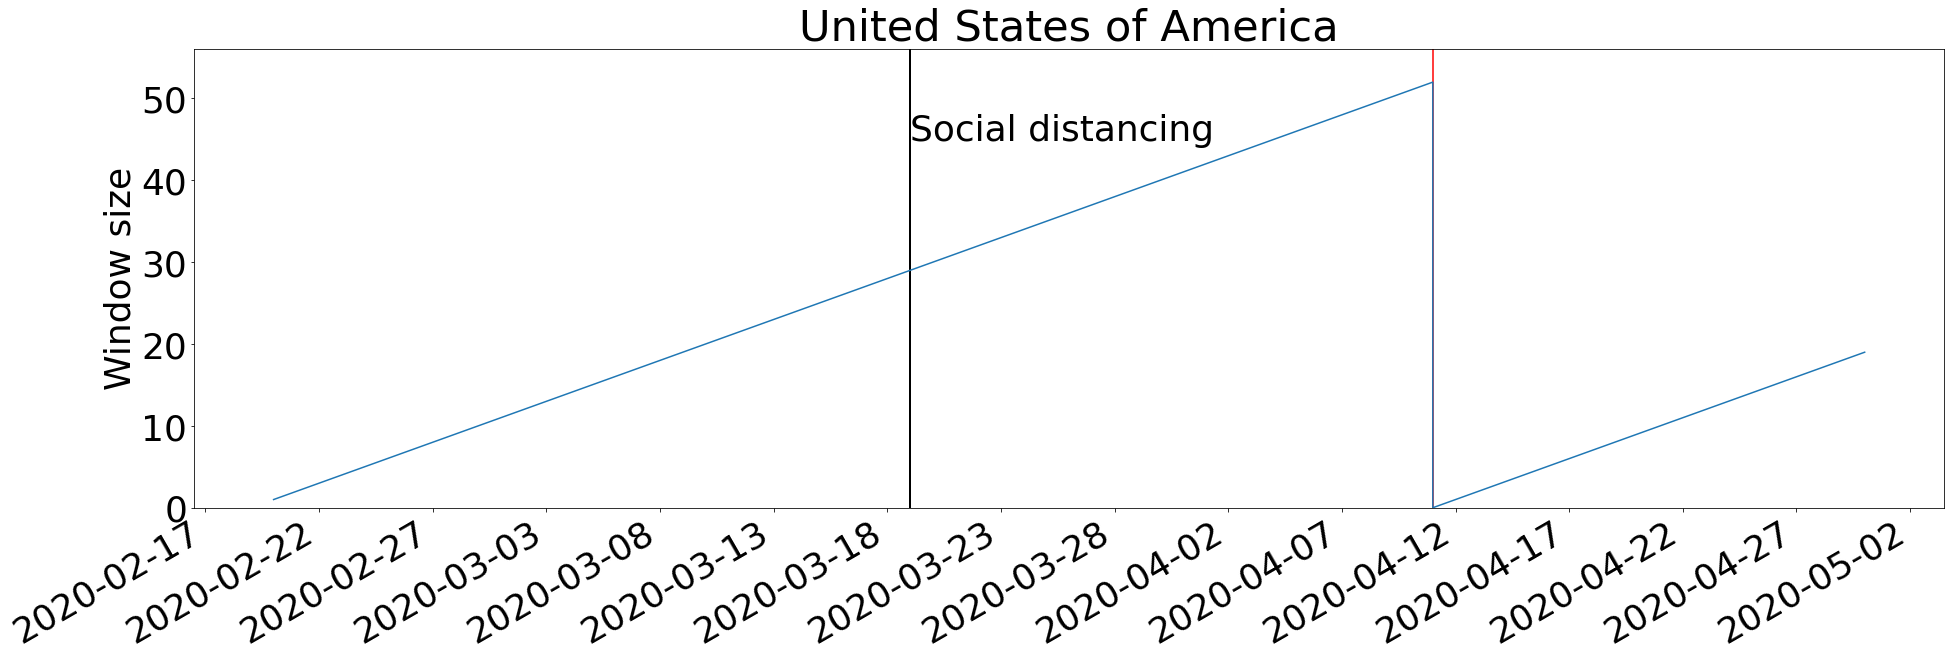

In [6]:
sigma_given=0.4 #hyperparameter for LNML of Gaussian
alpha_1, alpha_2 = calculate_alpha({"sigma_given": sigma_given}) # upper-bounds for 1st and 2nd D-MDL

print(alpha_1)
print(alpha_2)

parameters={"sigma_given": sigma_given, "alpha_1": alpha_1, "alpha_2": alpha_2}

os.makedirs("../../exponential_figs", exist_ok=True)

event_index_dict={}
alarm_0_dict={}
alarm_1_dict={}
alarm_2_dict={}
data_length_dict={}

for country in countries:
    events=events_all[country]
    print(country)
    alarm_0, alarm_1, alarm_2, event_index, data_length=country_graph(country, events, parameters)

    alarm_0_dict[country]=alarm_0
    alarm_1_dict[country]=alarm_1
    alarm_2_dict[country]=alarm_2
    event_index_dict[country]=event_index
    data_length_dict[country]=data_length

    

In [7]:
total_num_window_shrink=0 #done
num_detected_outbreak_either=0 #done
detection_rate=0 #done
days_prior_to_window_shrink_either=[]
allowed_window_shrink_1st=0 #done
allowed_window_shrink_2nd=0 # done
sign_detected_window_shrink_1st=0 #done
sign_detected_window_shrink_2nd=0 #done
days_prior_to_window_shrink_1st=[] #done
days_prior_to_window_shrink_2nd=[] #done

for country in countries:
    if country=='Ecuador':
        continue
    
    alarm_0=alarm_0_dict[country]
    alarm_1=alarm_1_dict[country]
    alarm_2=alarm_2_dict[country]
    event_index=event_index_dict[country]
    
    total_num_window_shrink+=len(alarm_0)
    
    for i in range(len(alarm_0)):
        if i==0:
            start=0
            end=alarm_0[i]
        else:
            start=alarm_0[i-1]+1
            end=alarm_0[i]
            
        if end-start+1>=11:
            allowed_window_shrink_1st+=1
        if end-start+1>=12:
            allowed_window_shrink_2nd+=1
        
        days_1st=-1
        days_2nd=-1
        
        # 1st D-MDL
        alarm_1=alarm_1[(start<= alarm_1) & (alarm_1<=end)]
        if len(alarm_1)==0:
            pass
        else:
            sign_detected_window_shrink_1st+=1
            days_prior_to_window_shrink_1st.append(end-alarm_1[0])
            days_1st=end-alarm_1[0]
        
        # 2nd D-MDL
        alarm_2=alarm_2[(start<= alarm_2) & (alarm_2<=end)]        
        if len(alarm_2)==0:
            pass
        else:
            sign_detected_window_shrink_2nd+=1
            days_prior_to_window_shrink_2nd.append(end-alarm_2[0])
            days_2nd=end-alarm_2[0]
            
        if len(alarm_1)+len(alarm_2)>=1:
            num_detected_outbreak_either+=1
            
        days_either=max(days_1st, days_2nd)
        if days_either!=-1:
            days_prior_to_window_shrink_either.append(days_either)
        
days_prior_to_window_shrink_either=np.array(days_prior_to_window_shrink_either)
days_prior_to_window_shrink_1st=np.array(days_prior_to_window_shrink_1st)
days_prior_to_window_shrink_2nd=np.array(days_prior_to_window_shrink_2nd)

print("Total number of window shrinks:", total_num_window_shrink)
print("Total number of detected window shrinks:", num_detected_outbreak_either)
print("Detection rate:", num_detected_outbreak_either/total_num_window_shrink)
print("Days by D-MDL:", np.mean(days_prior_to_window_shrink_either), "±", np.std(days_prior_to_window_shrink_either))
print("Allowed window shrinks for 1st D-MDL:", allowed_window_shrink_1st)
print("Allowed window shrinks for 2nd D-MDL:", allowed_window_shrink_2nd)
print("Detected window shrinks by 1st D-MDL:", sign_detected_window_shrink_1st)
print("Detected window shrinks by 2nd D-MDL:", sign_detected_window_shrink_2nd)
print("Days by 1st D-MDL:", np.mean(days_prior_to_window_shrink_1st), "±", np.std(days_prior_to_window_shrink_1st))
print("Days by 2nd D-MDL:", np.mean(days_prior_to_window_shrink_2nd), "±", np.std(days_prior_to_window_shrink_2nd))    

Total number of window shrinks: 54
Total number of detected window shrinks: 24
Detection rate: 0.4444444444444444
Days by D-MDL: 12.333333333333334 ± 8.98455464796237
Allowed window shrinks for 1st D-MDL: 53
Allowed window shrinks for 2nd D-MDL: 53
Detected window shrinks by 1st D-MDL: 24
Detected window shrinks by 2nd D-MDL: 6
Days by 1st D-MDL: 12.333333333333334 ± 8.98455464796237
Days by 2nd D-MDL: 5.166666666666667 ± 5.66911711723165


In [8]:
downward_countries=["Austria", "China", "Germany", "Iran", "Italy",
          "Netherlands", "Korea, South", "Spain", "Switzerland", "Turkey"]

num_alarms_before_sd_downward=[]
num_alarms_before_sd_not_downward=[]

#total alarms
num_alarms_total_downward=[]
num_alarms_total_not_downward=[]
#0th alarms
num_alarms_0th_downward=[]
num_alarms_0th_not_downward=[]
#1st alarms
num_alarms_1st_downward=[]
num_alarms_1st_not_downward=[]
#2nd alarms
num_alarms_2nd_downward=[]
num_alarms_2nd_not_downward=[]

num_days_window_shrink_downward=[]
num_days_after_downward=[]
    
for country in countries:
    if country=='Ecuador':
        continue

    alarm_0=alarm_0_dict[country]
    alarm_1=alarm_1_dict[country]
    alarm_2=alarm_2_dict[country]
    event_index=event_index_dict[country]
    data_length=data_length_dict[country]
        
    if country in downward_countries:
        num_alarms_total_downward.append(len(alarm_0)+len(alarm_1)+len(alarm_2))
        num_alarms_0th_downward.append(len(alarm_0))
        num_alarms_1st_downward.append(len(alarm_1))
        num_alarms_2nd_downward.append(len(alarm_2))
        num_alarms_before_sd_downward.append(len(alarm_0[alarm_0<=event_index])+len(alarm_1[alarm_1<=event_index])+len(alarm_2[alarm_2<=event_index]))
        if len(alarm_0[alarm_0>event_index])>0:
            num_days_window_shrink_downward.append(alarm_0[alarm_0>event_index][0]-event_index)
        else:
            num_days_window_shrink_downward.append(data_length-1-event_index)
    
    else:
        num_alarms_total_not_downward.append(len(alarm_0)+len(alarm_1)+len(alarm_2))
        num_alarms_0th_not_downward.append(len(alarm_0))
        num_alarms_1st_not_downward.append(len(alarm_1))
        num_alarms_2nd_not_downward.append(len(alarm_2))
        num_alarms_before_sd_not_downward.append(len(alarm_0[alarm_0<=event_index])+len(alarm_1[alarm_1<=event_index])+len(alarm_2[alarm_2<=event_index]))
        if len(alarm_0[alarm_0>event_index])>0:
            num_days_after_downward.append(alarm_0[alarm_0>event_index][0]-event_index)
        else:
            num_days_after_downward.append(data_length-1-event_index)            
    
num_alarms_before_sd_downward=np.array(num_alarms_before_sd_downward)
num_alarms_before_sd_not_downward=np.array(num_alarms_before_sd_not_downward)
num_days_window_shrink_downward=np.array(num_days_window_shrink_downward)
num_days_after_downward=np.array(num_days_after_downward)
        
print("Num of total alarms for downward countries", np.mean(num_alarms_total_downward), "±", np.std(num_alarms_total_downward))
print("Num of total alarms for non-downward countries",np.mean(num_alarms_total_not_downward), "±", np.std(num_alarms_total_not_downward))
print("Num of 0th alarms for downward countries", np.mean(num_alarms_0th_downward), "±", np.std(num_alarms_0th_downward))
print("Num of 0th alarms for non-downward countries",np.mean(num_alarms_0th_not_downward), "±", np.std(num_alarms_0th_not_downward))
print("Num of 1st alarms for downward countries", np.mean(num_alarms_1st_downward), "±", np.std(num_alarms_1st_downward))
print("Num of 1st alarms for non-downward countries",np.mean(num_alarms_1st_not_downward), "±", np.std(num_alarms_1st_not_downward))
print("Num of 2nd alarms for downward countries", np.mean(num_alarms_2nd_downward), "±", np.std(num_alarms_2nd_downward))
print("Num of 2nd alarms for non-downward countries",np.mean(num_alarms_2nd_not_downward), "±", np.std(num_alarms_2nd_not_downward))


Num of total alarms for downward countries 9.8 ± 7.152621896899066
Num of total alarms for non-downward countries 8.73076923076923 ± 9.525502984125914
Num of 0th alarms for downward countries 2.1 ± 0.8306623862918076
Num of 0th alarms for non-downward countries 1.2692307692307692 ± 0.5231334811052094
Num of 1st alarms for downward countries 6.9 ± 5.906775770248943
Num of 1st alarms for non-downward countries 6.846153846153846 ± 8.342164945404242
Num of 2nd alarms for downward countries 0.8 ± 1.469693845669907
Num of 2nd alarms for non-downward countries 0.6153846153846154 ± 2.3217520419671644
